## t-distributed Stochastic Neighbour Embedding
### a. SNE
- t-SNE uses various techniques to improve on SNE. The following notes summarises van der Maaten and Hinton (2008) [1].
- The technique tries to model high dimensional dataset $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$, with $\mathbf{x}_i \in \mathbb{R}^d, \ d > 3$, using a low dimensional embed (2D or 3D, for visualisation purposes) $\mathbf{y}_1, \mathbf{y}_2, \dots, \mathbf{y}_n$, with $\mathbf{y}_i \in \mathbb{R}^2$ or $\mathbf{y}_i \in \mathbb{R}^3$. Given $\mathbf{X}$, the goal is to find these embeds $\mathbf{Y}$.
- First SNE models the conditional probability of the original dataset, using a Gaussian pdf. Given fixed datapoint $\mathbf{x}_i$ is the mean of some Gaussian distribution, $P_i$ describe the probability that datapoint $\mathbf{x}_j$ is generated:
$$
  p_{j|i} = \frac{\exp{\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_j \|^2}{2\sigma_i^2}\right)}}{\sum_{k \neq i} \exp{\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_k \|^2}{2\sigma_i^2}\right)}}
$$
- with $\sigma_i$ being the variance of the Gaussian pdf, the method to find which will be discussed below; at the same time, the modeling defines $p_{i|i} \equiv 0$. The denominator is the normalizing factor to ensure $P_i$ is a proper pdf.
- Assume exists some embedding (for now just random 2D datapoints) $\mathbf{Y}$, we could define in a similar fashion the conditional probability $Q_i$:
$$
  q_{j|i} = \frac{\exp{\left(-\| \mathbf{y}_i - \mathbf{y}_j \|^2 \right)}}{\sum_{k \neq i} \exp{\left(-\| \mathbf{y}_i - \mathbf{y}_k \|^2 \right)}}
$$
- with variance equals to $\frac{1}{\sqrt{2}}$.
- The conditional for the "best" embedding is that these probabilities are similar to each other. Specifically, the sum of $n$ KL-divergences between 2 probability distributions $P_i$ and $Q_i$ are minimized. In other words, the method is trying to find $\mathbf{Y}$ optimizing the objective function $C$:
$$
  \begin{aligned}
  \mathbf{Y}
    &= \underset{\mathbf{Y}}{\text{argmin}}\ C(\mathbf{Y}) \\
    &= \underset{\mathbf{Y}}{\text{argmin}}\ \sum_i \text{KL}(P_i \| Q_i) \\
    &= \underset{\mathbf{Y}}{\text{argmin}}\ \sum_i \left( \sum_j p_{j|i} \ln{\frac{p_{j|i}}{q_{j|i}}} \right) \ \ \ \ (1)
  \end{aligned}
$$
- Intuitively, $\sigma_i$ should be small if $\mathbf{x}_i$ is from a dense region, large if sparse region, in other words lower & higher entropy respectively. The Shannon entropy is a good measure for this purpose:
$$
  H(P_i) = - \sum_j p_{j|i} log_2 p_{j|i}
$$
- Since $\sigma_i$ should varied if we want a faithful probabilistic modeling of $\mathbf{x}_i$, the model allows tuning a parameter called "perplexity" denote $\text{perp}$, which will indirectly determine Shannon score, and then $\sigma_i$ as a consequences:
$$
  \text{perp}(P_i) = 2^{H(P_i)}
$$
- In order to minimize the cost function defined at $(1)$, gradient descent is employed. The derivative of $C$ w.r.t. $\mathbf{y}_i$ is derived as:
$$
  \frac{\partial {C}}{\partial {\mathbf{y}_i}} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(\mathbf{y}_i - \mathbf{y}_j)
$$
- Starting with $\mathbf{Y}^{(0)} = \mathbf{Y}^{(-1)} \sim \mathcal{N}(\mathbf{0},\ \delta\mathbf{I}_2)$ - a set of points sampled from isotropic Gaussian with very small variance $\delta$, it follows typical gradient descent with momentum $m$ and learning rate $\alpha$ update:
$$
  \mathbf{Y}^{(t)} = \mathbf{Y}^{(t-1)} - \alpha \frac{\partial {C}}{\partial {\mathbf{Y}}} + m\left( \mathbf{Y}^{(t-1)} - \mathbf{Y}^{(t-2)} \right) \ \ \ \ (2)
$$
### b. t-SNE
- A few notable characteristics about SNE that make it undesirable and is improved by symmetric-SNE and t-SNE:
- 1. _Unwieldy computation involving_ $\exp$:
  - An alternative to modeling the probabilities $p_{j|i}$ and $q_{j|i}$ is to define a joint probability $p_{ij} = p_{ji}$ and $q_{ij} = q_{ji}$ with constant normalization factors that can be pre-computed, instead of $n$ times for each $i$. The models are just as sound as conditional probabilities counterparts:
$$
  \begin{aligned}
    q_{ij} = q_{ji} &= \frac{\exp{\left(-\| \mathbf{y}_i - \mathbf{y}_j \|^2 \right)}}{\sum_{k \neq l} \exp{\left(-\| \mathbf{y}_k - \mathbf{y}_l \|^2 \right)}}\\
    p_{i|j} = p_{j|i} &= \frac{\exp{\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_j \|^2}{2\sigma^2} \right)}}{\sum_{k \neq l} \exp{\left(-\frac{\| \mathbf{x}_k - \mathbf{x}_l \|^2}{2\sigma^2} \right)}}\\
    p_{ij} = p_{ji} &= \frac{p_{j|i} + p_{i|j}}{2n}
  \end{aligned}
$$
  - The last definition solves the problem of $p_{ij}$ being too small in situations where $\mathbf{x}_i$ is an outlier, which makes the norm-2 distance very large and $p_{j|i}$ too small.
- 2. _Mismatched dimensionalities and difficult-to-compute gradients_ (details are skipped in this notebook):
  - Student-t distribution with a single-degree of fredom is used to model the embedding $\mathbf{Y}$ probabilities instead of Gaussian, allowing a more faithful modeling of high-dimensional distances of dissimilar datapoints:
$$
  q_{ij} = q_{ji} = \frac{\left(1 + \| \mathbf{y}_i - \mathbf{y}_j  \|^2 \right)^{-1}}{\sum_{k \neq l} \left( 1 + \| \mathbf{y}_k - \mathbf{y}_l \|^2 \right)^{-1}}
$$
  - This simplifies the computation of the gradient of KL-divergences summation, since $\mathbf{P}$ matrix can be precomputed, and Student-t is faster to compute (for $\mathbf{Q}$ than Gaussian at each iteration (which involes $\exp$ evaluation):
$$
  \frac{\partial {C}}{\partial {\mathbf{y}_i}} = 4 \sum_j (p_{ij} - q_{ij})(\mathbf{y}_i - \mathbf{y}_j)\left( 1 + \| \mathbf{y}_i - \mathbf{y}_j \|^2 \right)^{-1}
$$
- The descent (with momentum) is done in a similar fashion, as defined at $(2)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_blobs

from sklearn.manifold import TSNE
from manifold.sne import SNE
from decomposition.PCA import PCA
from sklearn.preprocessing import StandardScaler


# synthetic data
rng = np.random.RandomState(42)

blobs_params = dict(random_state=0, n_samples=400, n_features=10)
blobs = np.dot(
            make_blobs(
                centers=[2*np.ones(10), (-2)*np.ones(10)],
                cluster_std=[0.5, 0.5],
                **blobs_params
            )[0],
            np.zeros((10, 10)) - 0.5 + np.diag(2*np.ones(10)))
outliers = rng.uniform(low=-30, high=30, size=(400, 10))

X = np.concatenate([blobs, outliers], axis=0)

# s-SNE
ssne = SNE(algo='SSNE')
y_ssne = ssne.fit(X)

# t-SNE
tsne = SNE(algo='TSNE')
y_tsne = tsne.fit(X)

# sklearn t-SNE
skltsne = TSNE(n_components=2, perplexity=40, early_exaggeration=6.0, learning_rate=10., n_iter=1600)
y_skltsne = skltsne.fit_transform(X)

# 2D PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
eigvals, eigvecs, explained = PCA(X_std)

W = eigvecs[:, :2] # first 2 principle axis
proj = X_std.dot(W)
plx = proj[:, 0]
ply = proj[:, 1]

==> s-SNE
== init P
== GDM
== GDM - iter ==  100
== GDM - iter ==  200
== GDM - iter ==  300
== GDM - iter ==  400
<==
==> t-SNE
== init P
== GDM
== GDM - iter ==  100
== GDM - iter ==  200
== GDM - iter ==  300
== GDM - iter ==  400
<==


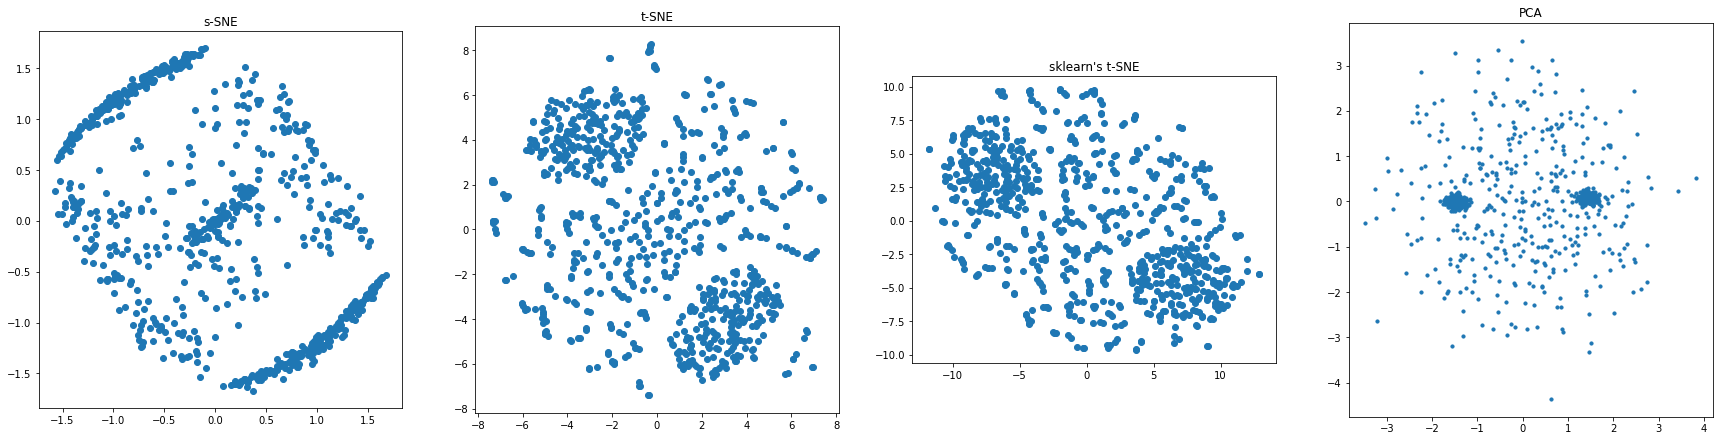

In [3]:
fig = plt.figure(figsize=(30, 30))

# s-sne
ax_ssne = fig.add_subplot(1, 4, 1)
ax_ssne.set_aspect('equal')
ax_ssne.set(title='s-SNE')
ax_ssne.scatter(y_ssne[:, 0], y_ssne[:, 1])

# t-sne
ax_tsne = fig.add_subplot(1, 4, 2)
ax_tsne.set_aspect('equal')
ax_tsne.set(title='t-SNE')
ax_tsne.scatter(y_tsne[:, 0], y_tsne[:, 1])

# sklearn t-sne
ax_skltsne = fig.add_subplot(1, 4, 3)
ax_skltsne.set_aspect('equal')
ax_skltsne.set(title='sklearn\'s t-SNE')
ax_skltsne.scatter(y_skltsne[:, 0], y_skltsne[:, 1])

# 2d pca
ax_pca = fig.add_subplot(1, 4, 4)
ax_pca.set_aspect('equal')
ax_pca.set(title='PCA')
ax_pca.scatter(plx, ply, s=10)

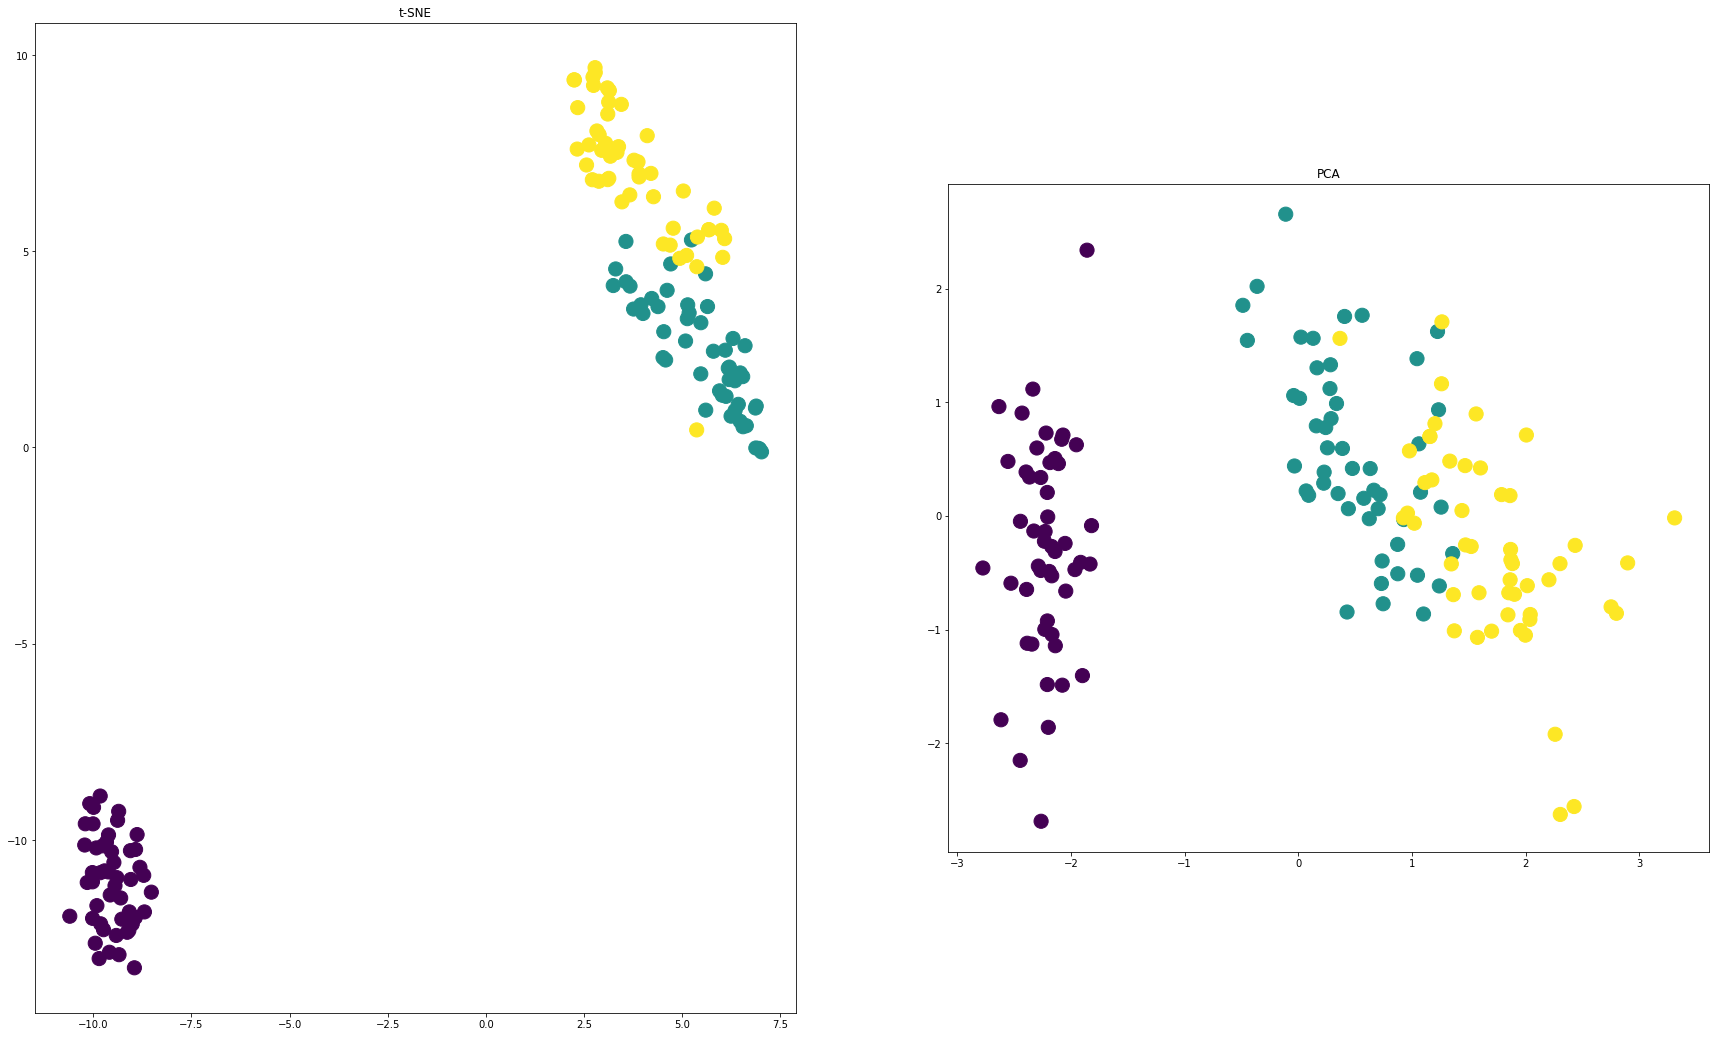

In [4]:
iris = load_iris()
X = iris.data
labels = iris.target

fig = plt.figure(figsize=(30, 30))

# t-SNE
y = TSNE(n_components=2, perplexity=40, n_iter=400).fit_transform(X)

ax_tsne = fig.add_subplot(1, 2, 1)
ax_tsne.set_aspect('equal')
ax_tsne.set(title='t-SNE')
ax_tsne.scatter(y[:, 0], y[:, 1], c=labels, s=200)

# pca
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
eigvals, eigvecs, explained = PCA(X_std)

W = eigvecs[:, :2] # first 2 principle axis
proj = X_std.dot(W)

plx = proj[:, 0]
ply = proj[:, 1]

ax_pca = fig.add_subplot(1, 2, 2)
ax_pca.set_aspect('equal')
ax_pca.set(title="PCA")
ax_pca.scatter(x=plx, y=ply, c=labels, s=200)

## References
- [1] van der Maaten, L. and G. Hinton (2008). Visualizing data using t-SNE. Journal of Machine Learning Research 9 (Nov), 2579–2605. Available at https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf